# [2.2 Tydzień 2](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-kohonen.html#org4d25730)

Do implementacji z zeszłego tygodnia dodać możliwość ułożenia neuronów w topologii siatki sześciokątnej.

Zastosować oba warianty topologii i obie funkcje sąsiedztwa do wektorów danych ze zbiorów

* MNIST
* https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

(sieć Kohonena uruchomić na zbiorach bez etykiet!).

Przeanalizować otrzymane mapowanie danych uwzględniając etykiety danych. Jak dobrze znalezione klastry odpowiadają podziałowi na klasy

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import copy
from sklearn import metrics
import seaborn as sns
sns.set_theme(style="whitegrid")


# Model

In [116]:
class model:

    def __init__(self, N, M, weights, t=1, metric='gaussian', topology = 'square'):
        self.N = N
        self.M = M
        self.weights = copy.deepcopy(weights)
        self.t = t
        assert topology in ['square', 'hexagon']
        self.topology = topology
        
        
        if metric == 'gaussian':
            self.metric = self.gaussian
        else:
            self.metric = self.gaussian2
        

    def train(self, data, epochs=100):
        for e in range(epochs):
            # np.random.seed(self.seed)
            p = np.random.permutation(data.shape[0])

            for x in data[p]:
                i_j = np.argmin([self.euclidean(x, y) for y in self.weights])
                for i, w in enumerate(self.weights):
                    if self.topology == 'square':
                        self.weights[i] = self.weights[i] + self.metric(self.euclidean(np.array([i//self.M, i % self.M]),
                                                                                       np.array([i_j//self.M,  i_j % self.M])),
                                                                        self.t) * np.exp(-(e+1)/epochs ) * (x - self.weights[i])
                    elif self.topology == 'hexagon':
                        if i//self.M % 2 == 1:
                            i_add = 1/2
                        else: 
                            i_add = 0
                        
                        if i_j//self.M % 2 == 1:
                            i_j_add = 1/2
                        else: 
                            i_j_add = 0
                        
                        self.weights[i] = self.weights[i] + self.metric(self.euclidean(np.array([i//self.M + i_add, i % self.M]),
                                                                                       np.array([i_j//self.M + i_j_add,  i_j % self.M])),
                                                                        self.t) * np.exp(-(e+1)/epochs ) * (x - self.weights[i])
                    
                    
    def predict(self, data):
        return [np.argmin([self.euclidean(w, x) for w in self.weights]) for x in data]

    @staticmethod
    def euclidean(x, y):

            return np.sqrt(((x-y) ** 2).sum())
        
    @staticmethod
    def gaussian(x, t):
        return np.exp(-(x * t) ** 2)

    @staticmethod
    def gaussian2(x, t):
        return (1 - 2 * x ** 2 * t ** 2) * 2 * t ** 2 * np.exp(-(x * t) ** 2)


## Hexagon  

Sprawdzimy model na wcześniejszych danych Hexagon - teoretycznie powinien mieć wyższe metryki.

In [117]:
train_df = pd.read_csv('../data/hexagon.csv')
x = np.asarray(train_df.iloc[:, [0, 1]])
N, M = 2, 3
weights = np.random.uniform(np.min(x), np.max(x), size=(N * M, x.shape[1]))

Text(0.5, 1.0, 't=2, cs=0.94, hs=0.94')

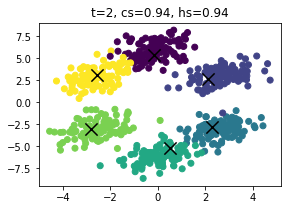

In [118]:
fig = plt.figure(figsize=(20,3))

plt.subplot(1, 4, 1)

kohonen = model(N,M, weights, t = 2, metric='gaussian')
kohonen.train(x, 100)

plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.scatter(kohonen.weights[:,0], kohonen.weights[:,1], marker='x', c='black', s= 150)
cs = metrics.completeness_score(train_df['c'], kohonen.predict(x) )
hs = metrics.homogeneity_score(train_df['c'], kohonen.predict(x))
plt.title(f't={kohonen.t}, cs={round(cs,2)}, hs={round(hs,2)}')

Text(0.5, 1.0, 't=2, cs=0.95, hs=0.95')

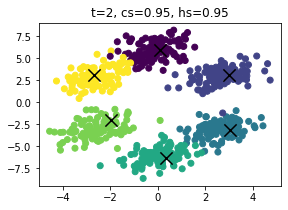

In [121]:
fig = plt.figure(figsize=(20,3))

plt.subplot(1, 4, 1)

kohonen = model(N,M, weights, t = 2, metric='gaussian', topology = 'hexagon')
kohonen.train(x, 100)

plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.scatter(kohonen.weights[:,0], kohonen.weights[:,1], marker='x', c='black', s= 150)
cs = metrics.completeness_score(train_df['c'], kohonen.predict(x) )
hs = metrics.homogeneity_score(train_df['c'], kohonen.predict(x))
plt.title(f't={kohonen.t}, cs={round(cs,2)}, hs={round(hs,2)}')

Faktycznie dla danych Hexagon, hexagonalne ustawienie neuronów lepiej się spisuje.

# Human+Activity+Recognition

In [38]:
x = np.asarray(pd.read_csv('../data/X_train.txt', header=None, sep="\s+"))
y = pd.read_csv('../data/y_train.txt', header=None, sep="\s+")

In [39]:
x.shape

(7352, 561)

In [40]:
resultsh = pd.DataFrame({'Zbiór':[], 'Architektura':[],'t':[], 'Metryka':[], 'Ulozenie':[], 'Homogenity Score':[], 'Completeness score':[]})

for architecture in [(2,3), (4,4), (6,6)]:
    for t in [0.1, 0.5, 1]:
        for metric in ['gaussian', 'gaussian2']:
            for topology in ['square', 'hexagon']:
                weights = np.random.uniform(np.min(x), np.max(x), size=(architecture[0] * architecture[1], x.shape[1]))
                kohonen = model(architecture[0],architecture[1] , weights, t = t, metric=metric, topology = topology)
                kohonen.train(x, 5)

                cs = metrics.completeness_score(np.array(y).reshape(-1), kohonen.predict(x) )
                hs = metrics.homogeneity_score(np.array(y).reshape(-1), kohonen.predict(x))

                resultsh = resultsh.append({'Zbiór':['HAR'], 'Architektura':[architecture],'t':[t], 'Metryka':[metric], 'Ulozenie':[topology], 'Homogenity Score':[hs], 'Completeness score':[cs]}, ignore_index=True)

/home/jakwisn/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-10-97e8e9bd9e98>:51: RuntimeWarning: overflow encountered in square
  return np.sqrt(((x - y) ** 2).sum())
<ipython-input-10-97e8e9bd9e98>:27: RuntimeWarning: overflow encountered in add
  self.weights[i] = self.weights[i] + self.metric(self.euclidean(np.array([i//self.M, i % self.M]),
<ipython-input-10-97e8e9bd9e98>:27: RuntimeWarning: invalid value encountered in add
  self.weights[i] = self.weights[i] + self.metric(self.euclidean(np.array([i//self.M, i % self.M]),
/home/jakwisn/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-10-97e8e9bd9e98>:51: RuntimeWarning: overflow encountered in square
  return np.sqrt(((x - y) ** 2).sum())
<ipython-in

In [53]:
for i in range(len(resultsh)): 
    for j in range(len(resultsh.iloc[i,:])): 
        resultsh.iloc[i,j] = resultsh.iloc[i,j][0]

Wyrzucam te gdzie homogenity score jest równe zero, nastąpiło tam overflow.

In [64]:
resultsh = resultsh[resultsh['Homogenity Score'] != 0]

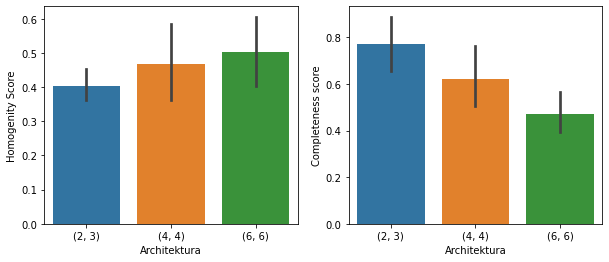

In [85]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Architektura", y="Homogenity Score", data=resultsh)

#  subplot #2
plt.subplot(122)
sns.barplot(x="Architektura", y="Completeness score", data=resultsh )

plt.show()

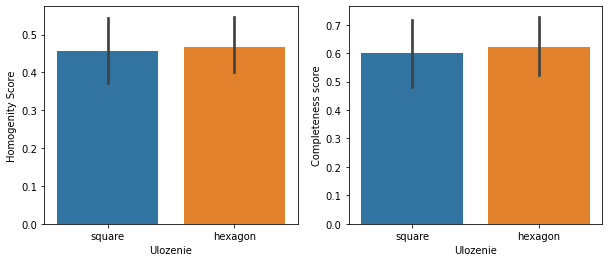

In [86]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Ulozenie", y="Homogenity Score", data=resultsh)

#  subplot #2
plt.subplot(122)
sns.barplot(x="Ulozenie", y="Completeness score", data=resultsh )

plt.show()

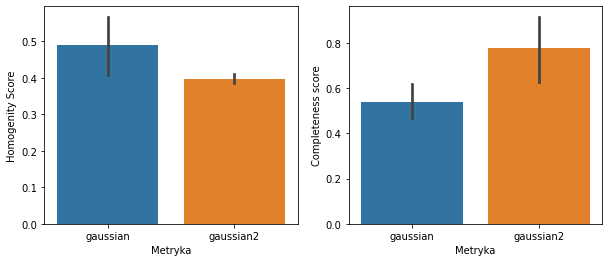

In [87]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Metryka", y="Homogenity Score", data=resultsh)

#  subplot #2
plt.subplot(122)
sns.barplot(x="Metryka", y="Completeness score", data=resultsh )

plt.show()

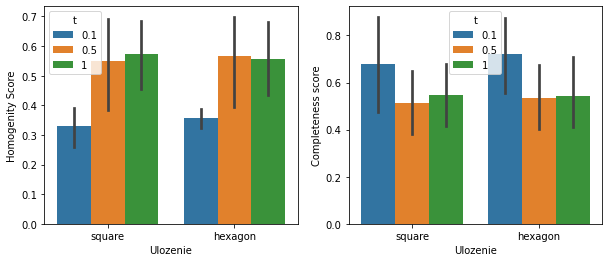

In [97]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Ulozenie", y="Homogenity Score", data=resultsh, hue='t')

#  subplot #2
plt.subplot(122)
sns.barplot(x="Ulozenie", y="Completeness score", data=resultsh, hue='t')

plt.show()

In [122]:
resultsh

,Zbiór,Architektura,t,Metryka,Ulozenie,Homogenity Score,Completeness score
0,H,"(2, 3)",0.1,gaussian,square,0.372936,0.954694
1,H,"(2, 3)",0.1,gaussian,hexagon,0.311317,0.772275
2,H,"(2, 3)",0.1,gaussian2,square,0.381395,0.979485
3,H,"(2, 3)",0.1,gaussian2,hexagon,0.380489,0.985031
4,H,"(2, 3)",0.5,gaussian,square,0.385478,0.649391
5,H,"(2, 3)",0.5,gaussian,hexagon,0.394832,0.672484
8,H,"(2, 3)",1,gaussian,square,0.552832,0.636806
9,H,"(2, 3)",1,gaussian,hexagon,0.45237,0.519879
12,H,"(4, 4)",0.1,gaussian,square,0.187888,0.429313
13,H,"(4, 4)",0.1,gaussian,hexagon,0.328846,0.75067


# MNIST 

In [32]:
import tensorflow as tf
data = tf.keras.datasets.mnist.load_data(path="mnist.npz")

In [33]:
x = data[0][0]
y = data[0][1]

In [34]:
x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

In [35]:
results = pd.DataFrame({'Zbiór':[], 'Architektura':[], 't':[], 'Metryka':[], 'Ulozenie':[], 'Homogenity Score':[], 'Completeness score':[]})

for architecture in [(2,3), (4,4), (6,6)]:
    for t in [0.1, 0.5, 1]:
        for metric in ['gaussian', 'gaussian2']:
            for topology in ['square', 'hexagon']:
                weights = np.random.uniform(np.min(x), np.max(x), size=(architecture[0] * architecture[1], x.shape[1]))
                kohonen = model(architecture[0],architecture[1] , weights, t = t, metric=metric, topology = topology)
                kohonen.train(x, 5)

                cs = metrics.completeness_score(np.array(y).reshape(-1), kohonen.predict(x) )
                hs = metrics.homogeneity_score(np.array(y).reshape(-1), kohonen.predict(x))

                results = results.append({'Zbiór':['MNIST'], 'Architektura':[architecture],'t':[t], 'Metryka':[metric], 'Ulozenie':[topology], 'Homogenity Score':[hs], 'Completeness score':[cs]}, ignore_index=True)

/home/jakwisn/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-10-97e8e9bd9e98>:51: RuntimeWarning: overflow encountered in square
  return np.sqrt(((x - y) ** 2).sum())
<ipython-input-10-97e8e9bd9e98>:27: RuntimeWarning: overflow encountered in add
  self.weights[i] = self.weights[i] + self.metric(self.euclidean(np.array([i//self.M, i % self.M]),
<ipython-input-10-97e8e9bd9e98>:27: RuntimeWarning: invalid value encountered in add
  self.weights[i] = self.weights[i] + self.metric(self.euclidean(np.array([i//self.M, i % self.M]),
/home/jakwisn/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-10-97e8e9bd9e98>:51: RuntimeWarning: overflow encountered in square
  return np.sqrt(((x - y) ** 2).sum())
<ipython-in

In [124]:
for i in range(len(results)): 
    for j in range(len(results.iloc[i,:])): 
        results.iloc[i,j] = results.iloc[i,j][0]



TypeError: 'float' object is not subscriptable

In [125]:
results = results[results['Homogenity Score'] > 0.0001]

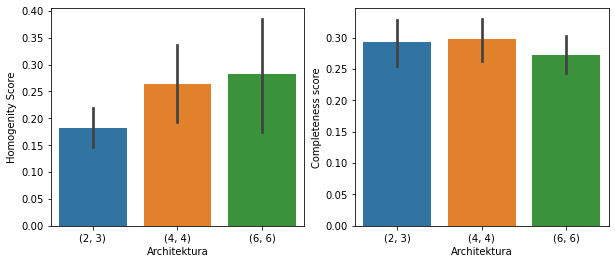

In [133]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Architektura", y="Homogenity Score", data=results)

#  subplot #2
plt.subplot(122)
sns.barplot(x="Architektura", y="Completeness score", data=results )

plt.show()

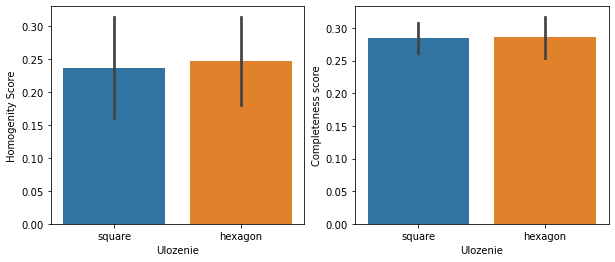

In [128]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Ulozenie", y="Homogenity Score", data=results)

#  subplot #2
plt.subplot(122)
sns.barplot(x="Ulozenie", y="Completeness score", data=results )

plt.show()

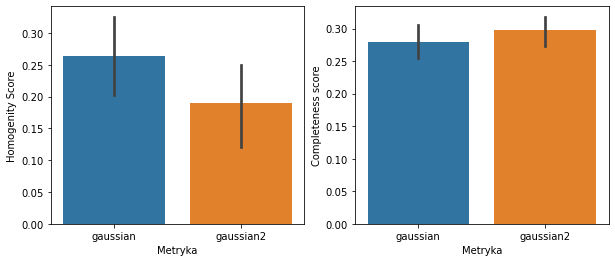

In [129]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Metryka", y="Homogenity Score", data=results)

#  subplot #2
plt.subplot(122)
sns.barplot(x="Metryka", y="Completeness score", data=results )

plt.show()

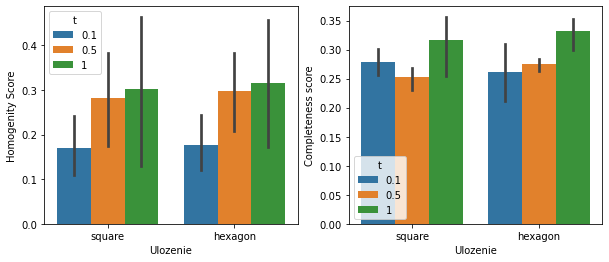

In [130]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
sns.barplot(x="Ulozenie", y="Homogenity Score", data=results, hue='t')

#  subplot #2
plt.subplot(122)
sns.barplot(x="Ulozenie", y="Completeness score", data=results, hue='t')

plt.show()

In [131]:
results

,Zbiór,Architektura,t,Metryka,Ulozenie,Homogenity Score,Completeness score
0,H,2,0.1,gaussian,square,0.0602395,0.256223
1,HAR,"(2, 3)",0.1,gaussian,hexagon,0.11551,0.210403
2,HAR,"(2, 3)",0.1,gaussian2,square,0.136107,0.305316
3,HAR,"(2, 3)",0.1,gaussian2,hexagon,0.147132,0.335049
4,HAR,"(2, 3)",0.5,gaussian,square,0.173761,0.230546
5,HAR,"(2, 3)",0.5,gaussian,hexagon,0.207314,0.280287
8,HAR,"(2, 3)",1,gaussian,square,0.247388,0.336253
9,HAR,"(2, 3)",1,gaussian,hexagon,0.246011,0.353645
12,HAR,"(4, 4)",0.1,gaussian,square,0.126639,0.273279
13,HAR,"(4, 4)",0.1,gaussian,hexagon,0.107103,0.208225


# Wnioski
Ułożenie hexagonalne daje delikatnie lepsze wyniki. Metryka meksykańskiego kapelusza wciąż sprawia problemy i zdecytowanie bardziej promuje completeness score, co jest logiczne, gdyż jak widzieliśmy wcześniej neurony są raczej skupione w jednym miejscu. 